<a href="https://colab.research.google.com/github/AnalystGagan/Project-dog-vision/blob/master/Project_dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 End-to-End Multi-Class Dog Breed Classification

This notebook builds an End-to-end Multi-Class Image Classifier using Tensorflow Hub.


## 1.Problem
Identifying the breed of a dog given an image of a dog

When I am sitting at the Starbucks and I take a photo of a dog, want to know what breed of a dog it is. 
## 2.Data 
The data we are using is from Kaggel's dog breed identification compitition 

https://www.kaggle.com/c/dog-breed-identification/data
## 3.Evaluation
The Evaluation is a file with prediction probabilities for each dog breed of each test Image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation
## 4.Features
Some information about the data:

* we are dealing with images (unstructured data ) so it is probably best se use deep learning/ transfer learning. 
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in training dataset (These images has labels)
* There are around 10,000+ images in test dataset (These images do not have labels, becasue we'll want to predict them).





In [ ]:
# Unzip the uploaded data into google Drive
 
#!unzip "drive/My Drive/dog-vision-data/dog-breed-identification.zip" -d "drive/My Drive/dog-vision-data/"

### Getting our workspace ready 

* Import TensorFlow 2.x ✔️
* Import TensorFlow Hub ✔️
* Make sure we are using a GPU ✔️


In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version :", tf.__version__)
print("TF Hub version:",hub.__version__)
 
# Check for GPU availablity 
print("GPU","available (Yessssssss!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version : 2.2.0
TF Hub version: 0.8.0
GPU available (Yessssssss!!!!)


## Getting our data ready (Turning into Tensors)

With all Machine Leanring models, our data has to be in numerical format. So that's what we will be doing first. Turning our images into Tensors(numerical representations)

Let's start by accessing our data and checking out checking out the labels.

In [ ]:
# Checkout the labels of our data 
import pandas as pd 
# Path --> /content/drive/My Drive/dog-vision-data/labels.csv
labels_csv = pd.read_csv("drive/My Drive/dog-vision-data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fcbad8ad476b83b180c9497bba2dedba  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# How many images are there of each breed
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

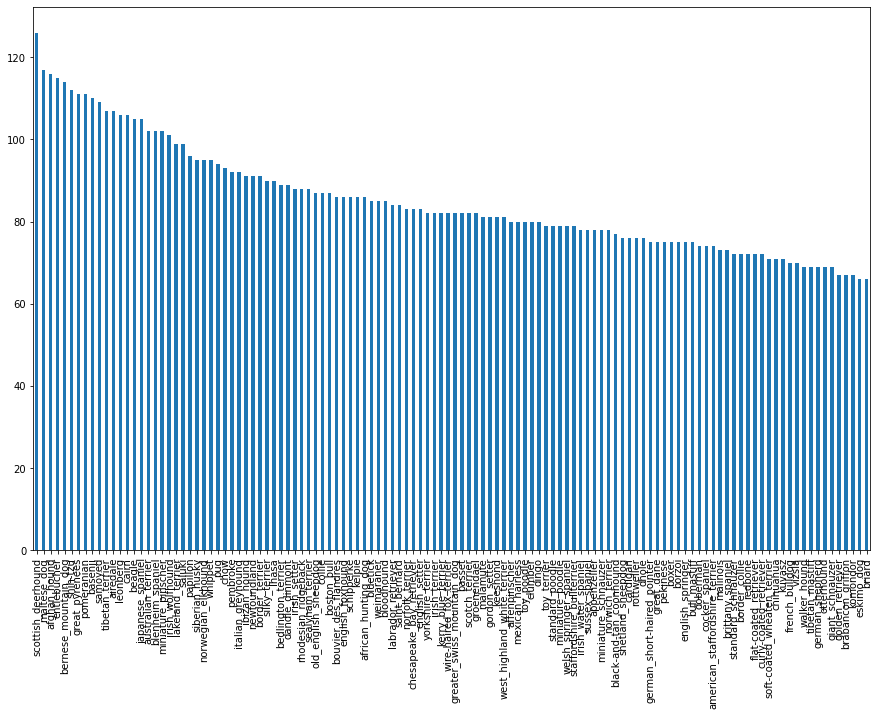

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize = (15,10));

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

*** Good start, our dataset is balance accross each class of breed. 
Google recommends minimum number of images per class should be 10*** 
https://cloud.google.com/vision/automl/object-detection/docs/prepare

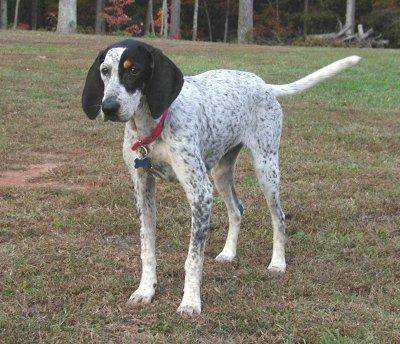

In [ ]:
# Let's view an image 
from IPython.display import Image
Image("drive/My Drive/dog-vision-data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels 

Let's get a list of all of our image file pathnames. 

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# Create a path name from image ID's 
filename = ["drive/My Drive/dog-vision-data/train/"+fname + ".jpg" for fname in labels_csv["id"]]
 
# Check for the first 10
filename[:10]

['drive/My Drive/dog-vision-data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog-vision-data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog-vision-data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog-vision-data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog-vision-data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/dog-vision-data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/dog-vision-data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/dog-vision-data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/dog-vision-data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/dog-vision-data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check wheather number of filename matches with number of actual image files
import os 
if len(os.listdir("drive/My Drive/dog-vision-data/train/")) == len(filename):
  print("filename matches  actual numeber of files, Proceed")
else:
  print("filename donot match actual amount of files, check the target directory")

filename matches  actual numeber of files, Proceed


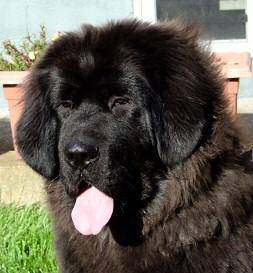

In [ ]:
# One more check 
Image(filename[998])

In [ ]:
# Great!! Now, lets find out the breed of this dog 
labels_csv["breed"][999]

'irish_wolfhound'

Since we have now got our training image filepath in a list, let's prepare our labels

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels = np.array(lables) # does the same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if the number of labels matches with number of filenames 
if len(labels) == len(filename):
  print("Number of labels matches with number of file names ")
else:
  print("Number of labels does not match with number of file names")

Number of labels matches with number of file names 


In [ ]:
# Find the unique label vlaues
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of boolens
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Tuen evey label into boolen array
boolen_labels = [label == unique_breeds for label in labels]
boolen_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolen_labels)

10222

In [ ]:
# Example: Turing boolen array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) # index where labels occurs
print(boolen_labels[0].argmax()) # index where label occurs in boolen array
print(boolen_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolen_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]






 ### Creating our own Validation set 
 Since, the dataset from kaggel does not come with a validation set, we are going to create our own

In [ ]:
 
# Setup X and y variables
 
X = filename
y = boolen_labels

We are going to start off experimenting with ~1000 images and increase as needed

In [ ]:
# Set the number of images to use for experimenting 
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Let's split our data into train and validation sets
from sklearn .model_selection import train_test_split
# np.random.seed(42)
# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size = 0.2, random_state = 42)
 
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# lets have a look at training data
X_train[:2], y_train[:2]

(['drive/My Drive/dog-vision-data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/dog-vision-data/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False

## Preprocessing Images (Turning Images into Tensors)

To preprocess our Images into Tensors . we're going to write a function which does a few things: 

1. Take the image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` jpg into Tensors 
3. Resize the `image` to be a shape of (224,224)
4. Return the modified `image`

Before we do, lets see what importing an image looks like.

In [ ]:
# Convert Image to NumPy array 
from matplotlib.pyplot import imread
image = imread(filename[42])
image.shape
# Image is a combinatiomn of red,green and blue pixel values

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
# Turn image into a Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now, we have seen what an image looks like as a Tensor, let's make a function to preprocess them. 

1. Take the image filepath as input
2. Use Tensorflow to read the file and save it to a variable, image
3. Turn our image jpg into Tensors
4. Normalize our image (convert color channel value from 0-255 to 0-1).
5. Resize the image to be a shape of (224,224)
6. Return the modified image

In [ ]:
# Define image size
IMG_SIZE = 224
 
# Create a function to preprocess images 
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an Image file 
  image = tf.io.read_file(image_path)
  # Turn the Jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values 
  image = tf.image.convert_image_dtype(image, tf.float32) # data normalization
  # Resize the image to our desire value (224,224)
  image= tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
 
  return image

### Turning our data into batches 

Why turn our data into batches 

Let's say you are trying to process 10,000+ images in one go... they all might not fit into memory. 

So that is why we do about 32 (this is the batch size)  images at a time( you can manually adjust the batch size if need be).

https://twitter.com/ylecun/status/989610208497360896?s=20

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`




In [ ]:
# Create a simple function to return a tuple (image, label) 
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Demo of the above 
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now, we have got a way to turnb our data into tuple of Tensors in the form `image, label`. Let's make a function to turn all of our data (`X`& `y`) into batches

In [ ]:
# Define a batch size , 32 is a good start 
BATCH_SIZE = 32
 
# Create a function to turn data into batches 
 
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it is training data but does not shuffle if it is validation data.
  Also, accepts test data as input (no lables)
  """
  # If data is a test dataset, we probably do not have labels 
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepath no label
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
 
  # if data is a valid dataset, we don't need to shuffle it 
  elif valid_data: 
    print(" Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths 
                                               tf.constant(y))) #lables
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)  
    return data_batch
  else: 
    print("Creating training data batches.... ")
    # Turn filepath and label into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
 
    # Shuffeling pathname nad labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size = len(X)) 
 
    # Create (image, label) tuples (this also turns the images path into a preprocessed image) 
    data = data.map(get_image_label)   
 
    # Turn the training data into batches 
    data_batch = data.batch(BATCH_SIZE)
           
    return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data=True )

Creating training data batches.... 
 Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data in now in batches , however these can be a little hard to understand/ comprehend , Let's visualize them 

In [ ]:
import matplotlib.pyplot as plt
 
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure 
  plt.figure(figsize =(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
  # Create subplots (5 rows, 5 columns)
   ax = plt.subplot(5,5,i+1)
  # Display an image 
   plt.imshow(images[i])
  # Add the image label as the tile 
   plt.title(unique_breeds[labels[i].argmax()])
  # Turn the grid lines off
   plt.axis("off")

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

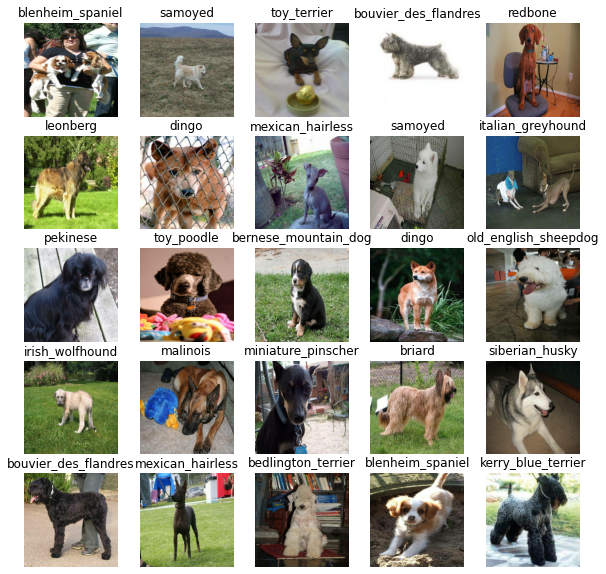

In [ ]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

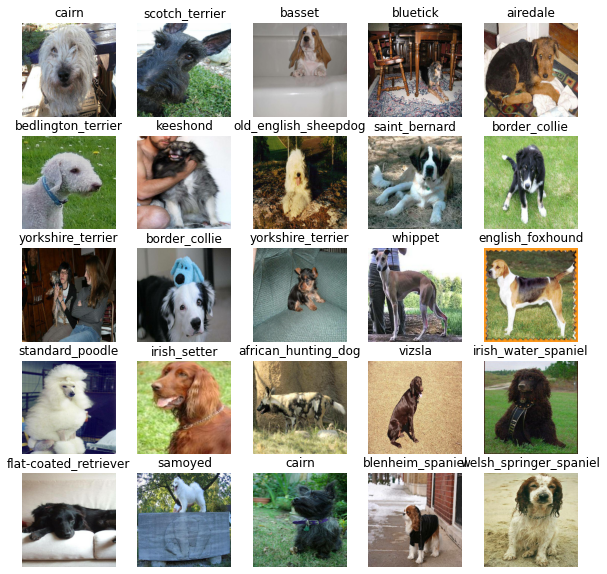

In [ ]:
# Now let's visualize our valuization set 
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

##  Building a model 

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the from of Tensors) to our model. 
* The output shape( image labels, in the form of Tensors) of our model. 
* The URL of them model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4



In [ ]:
# Setup input shape to the model 
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height , eidth , colour channels
 
# Setup output shape of our model
OUTPUT_SHAPE  = len(unique_breeds) 
 
# Setup model URL from TensorFlow hub 
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we have got our inputs, outputs and model ready to go.
Let's put them together into a Keras deep learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we have choosen as parameters. 
* Define the layers in a Kares model in sequential fashion ( do this first, then this, then that)
* Compiles the model (says it should be evaluated and improved).
* Builds the model ( tells the model the input shape it will be getting).
* Returns the model

All these steps can be found here - https://www.tensorflow.org/guide/keras/functional


In [ ]:
# Create a function which builds a Keras model 
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Build a model with: " , MODEL_URL)
 
  # Setup model layers 
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer1(input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation = "softmax") # layer2 (Output layer)
  ])
 
  # Compile the model 
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
 
  )
 
  # Build the model 
  model.build(INPUT_SHAPE)
 
  return model

In [ ]:
model = create_model()
model.summary()

Build a model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving. 

We will create two callbacks, one for TensorBoard which helps track our model progress and another for early  stopping which prevents our model from training for too long. 

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. create a TensorBoard callback which is able to save logs to a directory and passit to our model's `fit()` function. 
3. visualize our model's training log with the `%tensorboard` magic function(we will do this after model training).



In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
 
# Create a function to build a TensorBoard callback 
def create_tensorboard_callback():
  # Create a log directory for stroing TensorBoard logs
  logdir = os.path.join("drive/My Drive/dog-vision-data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d - %H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback 

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving 

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# Create early stopping callback 
 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                patience= 3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# check to make sure we're still running on GPU 
print("GPU", "available (Yess!!!!" if tf.config.list_physical_devices("GPU") else "not available")

GPU available (Yess!!!!


Let's create a function which trains a model. 
* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCUS) and thecallback we'd like to use
* Return the mod

In [ ]:
# Build a function to train and return a trained model 
def train_model():
  """
  trains a given model and returns the trained version.
  """
 
  # Create a model 
  model = create_model()
 
  # Create new new TensorBoard session everytime we train a model 
  tensorboard = create_tensorboard_callback()
 
  # Fit the model to the data passing it the callback we created 
  model.fit(x=train_data, 
            epochs = NUM_EPOCHS,
            validation_data= valid_data,
            validation_freq = 1,
            callbacks = [tensorboard, early_stopping])
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Build a model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 350s 14s/step - loss: 4.5366 - accuracy: 0.1163 - val_loss: 3.5953 - val_accuracy: 0.2200
Epoch 2/100
25/25 [==============================] - 6s 243ms/step - loss: 1.6227 - accuracy: 0.6787 - val_loss: 2.2616 - val_accuracy: 0.4500
Epoch 3/100
25/25 [==============================] - 6s 243ms/step - loss: 0.5659 - accuracy: 0.9275 - val_loss: 1.7531 - val_accuracy: 0.5600
Epoch 4/100
25/25 [==============================] - 6s 242ms/step - loss: 0.2586 - accuracy: 0.9800 - val_loss: 1.5386 - val_accuracy: 0.5900
Epoch 5/100
25/25 [==============================] - 6s 244ms/step - loss: 0.1475 - accuracy: 0.9962 - val_loss: 1.4746 - val_accuracy: 0.6100
Epoch 6/100
25/25 [==============================] - 6s 245ms/step - loss: 0.1017 - accuracy: 0.9987 - val_loss: 1.4280 - val_accuracy: 0.6150
Epoch 7/100
25/25 [==============================

In [ ]:
model

**Looks like our model is overfitting becasue it is performing far better on training dataset than validation dataset . what are some ways to prevent model overfitting in deep learning neural networks ?**

Overfitting to begin with is a good thing! it means our model is learning!!!

### Checking the TensorBoard logs 

The TensorBoard magic function (%tensorboard) will access the logs directory we created earlier and visualize its contents. 


In [ ]:
%tensorboard --logdir drive/My\ Drive/dog-vision-data/logs

Reusing TensorBoard on port 6006 (pid 2225), started 0:00:11 ago. (Use '!kill 2225' to kill it.)

<IPython.core.display.Javascript object>

## Making and evaluating prediction using trained model 

In [ ]:
valid_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Making prediction on validation data (not used on training)
 
predictions = model.predict(valid_data, verbose = 1)
predictions

7/7 [==============================] - 1s 164ms/step


array([[2.1950533e-03, 2.1790441e-04, 2.2589107e-04, ..., 8.7259983e-04,
        1.6581853e-05, 2.1937117e-03],
       [1.0154468e-03, 1.0317374e-03, 5.0859964e-03, ..., 2.2619858e-03,
        7.3781685e-04, 9.0607260e-05],
       [4.2434818e-05, 8.5533844e-05, 1.3476057e-05, ..., 5.9385817e-05,
        6.6133325e-05, 2.4850925e-03],
       ...,
       [4.2584693e-06, 8.9236841e-05, 1.0615416e-03, ..., 2.2180755e-05,
        4.9459046e-05, 3.6309543e-04],
       [1.0612656e-02, 6.3735596e-04, 5.5354751e-05, ..., 3.5238793e-04,
        8.9416659e-05, 5.2802623e-03],
       [4.8098744e-05, 1.2868817e-05, 5.3045439e-04, ..., 9.4963901e-04,
        3.0533900e-03, 4.2373220e-05]], dtype=float32)

In [ ]:
predictions.shape

(200, 120)

In [ ]:
len(valid_data)

TypeError: ignored

In [ ]:
len(unique_breeds)

120

In [ ]:
len(predictions[0])

120

In [ ]:
np.sum(predictions[0])

1.0

In [ ]:
# Frist prediction
index = 0 
print(predictions[index])
print(f"Max value (probablity of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index : {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[2.19505327e-03 2.17904410e-04 2.25891068e-04 3.42925341e-04
 1.20588455e-04 7.99188929e-05 3.26253697e-02 7.44473247e-04
 2.90584067e-05 3.90626257e-03 5.10700338e-04 3.71008267e-04
 9.68945315e-05 1.61903547e-04 2.49006925e-03 4.33147419e-04
 7.58046590e-05 1.11646771e-01 2.09139453e-05 7.27055158e-05
 4.98825265e-03 7.13807123e-04 2.14859519e-05 3.54109425e-03
 1.17261561e-05 2.82950955e-03 1.10292085e-01 8.80116131e-05
 4.59682895e-04 1.10058195e-03 8.79070576e-05 6.74873241e-04
 3.04756430e-03 5.62130808e-05 9.08859365e-05 2.22836286e-02
 1.00645993e-05 1.09358967e-04 4.23723104e-04 2.97734485e-04
 4.69562074e-04 1.26145578e-05 1.12217059e-03 2.95819103e-04
 2.01750627e-05 1.05303829e-03 2.64291302e-05 4.15209128e-04
 4.63054566e-05 7.24566125e-05 4.67610313e-04 7.24488054e-05
 1.00702071e-03 2.81545595e-04 1.95328248e-04 1.22071957e-04
 2.41049391e-04 6.39753463e-03 6.50847942e-05 8.61556903e-02
 4.62184078e-04 5.56883533e-05 1.42013212e-03 2.38869121e-04
 3.39641032e-04 2.522023

Having the above functionality is great but we want to be able to do it at scale 

And it would be even better if we could see the image the prediction is being made on!

**Note**:Prediction probablities are also known as confidence levels  


In [ ]:
# Turn prediction probablities into their respective label (easier to understand)
 
def get_pred_label(prediction_probabilities):
  """
  Turn an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]
 
# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Now since our validation data is stillin a batch dataset, we will have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels(truth labels).

In [ ]:
valid_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels


In [ ]:
# Unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we have got way to get :
* Prediction labels 
* Validation labels(truth label)
* validation images 

Let's make some function to make these all a bit more visualize 

we will create a funtion which:

* Take an array of prediction probabilities, an array of truth labels and an array of images and an interger 
* Convert the prediction probabnilities to prediction label
* Plot the predicted label, its predicted probablitiy, the truth label and the target image on a single plot. 

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n],images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks 
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong 
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Chnage plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                  np.max(pred_prob)*100,
                                  true_label),
                                  color=color)


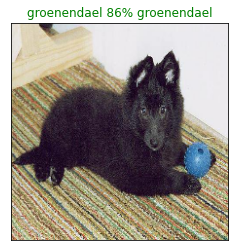

In [ ]:
plot_pred(prediction_probabilities = predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:

* Take an input of prediction probabilities array and a ground truth array and an interger
* Fund the prediction using `get_pred_label`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green 

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest predictions confidences along with the truth label for sampel n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction label
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass



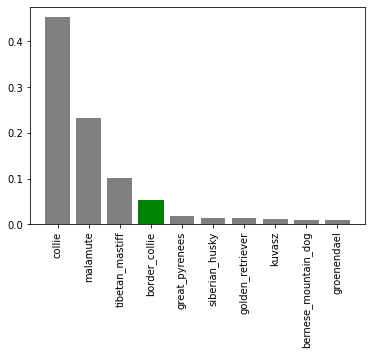

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.

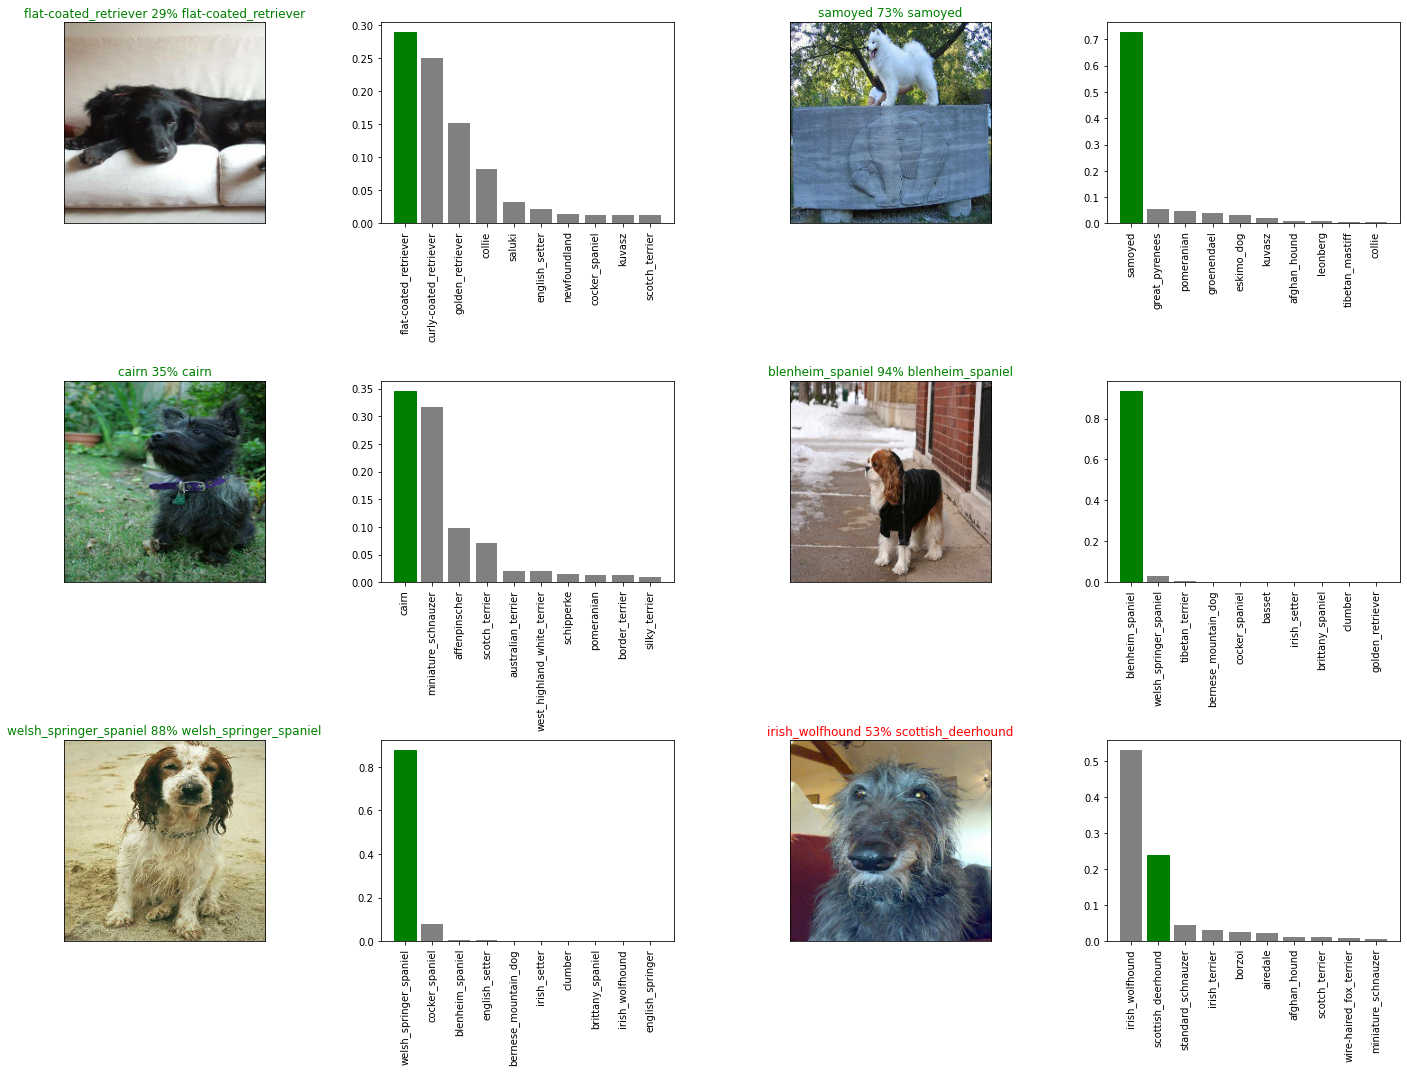

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

### Saving and reloading a trained model

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/dog-vision-data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/dog-vision-data/models/20200727-17151595870141-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/dog-vision-data/models/20200727-17151595870141-1000-images-mobilenetv2-Adam.h5'

In [ ]:

# Load a trained model
loaded_1000_image_model = load_model('drive/My Drive/dog-vision-data/models/20200727-17151595870141-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/dog-vision-data/models/20200727-17151595870141-1000-images-mobilenetv2-Adam.h5


## Training a big dog model 🐶 (on the full data)


In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches.... 


In [ ]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a model for full model
full_model = create_model()

Build a model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:

# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 4479s 14s/step - loss: 1.3323 - accuracy: 0.6724
Epoch 2/100
320/320 [==============================] - 73s 229ms/step - loss: 0.4005 - accuracy: 0.8816
Epoch 3/100
320/320 [==============================] - 71s 223ms/step - loss: 0.2356 - accuracy: 0.9359
Epoch 4/100
320/320 [==============================] - 71s 223ms/step - loss: 0.1527 - accuracy: 0.9617
Epoch 5/100
320/320 [==============================] - 71s 223ms/step - loss: 0.1085 - accuracy: 0.9767
Epoch 6/100
320/320 [==============================] - 73s 229ms/step - loss: 0.0771 - accuracy: 0.9875
Epoch 7/100
320/320 [==============================] - 72s 225ms/step - loss: 0.0592 - accuracy: 0.9913
Epoch 8/100
320/320 [==============================] - 72s 226ms/step - loss: 0.0461 - accuracy: 0.9942
Epoch 9/100
320/320 [==============================] - 71s 223ms/step - loss: 0.0372 - accuracy: 0.9963
Epoch 10/100
320/320 [==============================] - 73s 228m

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/dog-vision-data/models/20200727-18521595875929-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/dog-vision-data/models/20200727-18521595875929-full-image-set-mobilenetv2-Adam.h5'

In [ ]:
# Load in the full model
loaded_full_model = load_model('drive/My Drive/dog-vision-data/models/20200727-18521595875929-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/dog-vision-data/models/20200727-18521595875929-full-image-set-mobilenetv2-Adam.h5


In [ ]:
loaded_full_model

### Making predictions on custom images

To make predictions on custom images, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [ ]:
# Get custom image filepaths
custom_path = "drive/My Drive/dog-vision-data/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:

custom_image_paths

['drive/My Drive/dog-vision-data/my-dog-photos/Image1.jpeg',
 'drive/My Drive/dog-vision-data/my-dog-photos/Image2.jpeg',
 'drive/My Drive/dog-vision-data/my-dog-photos/Image3.jpeg']

In [ ]:
# Turn custom images into batch datasets 
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:

custom_preds.shape

(3, 120)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['labrador_retriever', 'pug', 'labrador_retriever']

In [ ]:

# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

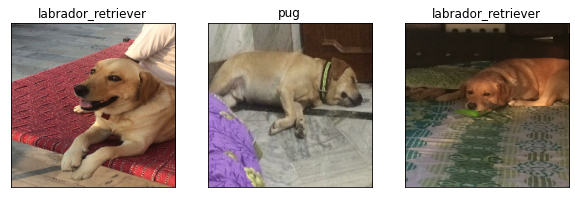

In [ ]:

# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)